# Visualisation of the Impact of Normalising Flow

In [1]:
%run imports.py

All packages loaded successfully.


In [3]:
def normalise_flow_kl(X_train, prior_kl, post_kl):

    X_2d = X_train.reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth='scott').fit(X_2d)
    log_p_x = kde.score_samples(X_2d)
    log_p_z = norm.logpdf(X_train)
    kl_div = np.mean(log_p_x - log_p_z)
    prior_kl.append(kl_div)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1,1))
    
    n_flow = Normalizer(X_train, log=False)
    opt_flow = gpflow.optimizers.Scipy()
    opt_flow.minimize(n_flow.KL_objective, n_flow.trainable_variables)
    
    X_transformed = n_flow.bijector(X_train).numpy()

    X_transformed_2d = X_transformed.reshape(-1, 1)
    kde_after = KernelDensity(kernel='gaussian', bandwidth='scott').fit(X_transformed_2d)
    log_p_transformed = kde_after.score_samples(X_transformed_2d)
    log_p_z_after = norm.logpdf(X_transformed)
    kl_div_after = np.mean(log_p_transformed - log_p_z_after)
    post_kl.append(kl_div_after)

    return X_transformed

In [4]:
# Gaussian datasets

prior_kl_gauss = []
post_kl_gauss = []

dataset_size = 500

n_gauss = 200
mean_arr = np.random.uniform(-5, 5, size=n_gauss)
std_arr = np.abs(np.random.normal(0, 2.5, size=n_gauss))

for i in range(n_gauss):
    X = np.random.normal(loc=mean_arr[i], scale=std_arr[i], size=dataset_size)
    _ = normalise_flow_kl(X, prior_kl_gauss, post_kl_gauss)

In [5]:
# Uniform datasets

prior_kl_unif = []
post_kl_unif = []

dataset_size = 500

n_unif = 200
lb_arr = np.random.uniform(-5, 5, size=n_unif)
ub_arr = lb_arr + np.abs(np.random.uniform(0.1, 5, size=n_unif))

for i in range(n_unif):
    X = np.random.uniform(lb_arr[i], ub_arr[i], size=dataset_size)
    _ = normalise_flow_kl(X, prior_kl_unif, post_kl_unif)

In [6]:
# Mixture of Gaussians

prior_kl_mog = []
post_kl_mog = []

dataset_size = 500

n_mog = 300

for i in range(n_mog):
    num_gaussians = np.abs(int(np.random.normal(loc=0, scale=2))) + 1
    mean_arr = np.random.uniform(-12, 12, size=num_gaussians)
    std_arr = np.abs(np.random.normal(0, 2.5, size=num_gaussians))
    weights_arr_unn = np.random.uniform(0, 20, size=num_gaussians)
    weights_arr = weights_arr_unn / np.sum(weights_arr_unn)

    component_choices = np.random.choice(num_gaussians, size=dataset_size, p=weights_arr)
    X = np.random.normal(loc=mean_arr[component_choices], scale=std_arr[component_choices])
    _ = normalise_flow_kl(X, prior_kl_mog, post_kl_mog)

In [7]:
# Real Life Distributions

def concrete_data():

    concrete = fetch_ucirepo(id=165)

    df = concrete.data.features.copy()
    df = df.select_dtypes(include='number')
    y_target = concrete.data.targets.copy()

    X = df.to_numpy()
    y = y_target.to_numpy()
    y = y.reshape(-1, 1)

    # Create training and testing data split:
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    X_train, X_test, y_train, y_test = None, None, None, None
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        break

    y_mean, y_std = np.mean(y_train), np.std(y_train)
    y_train = (y_train - y_mean) / y_std
    y_test = (y_test - y_mean) / y_std


    return X_train, X_test, y_train, y_test, y_mean, y_std

def autompg_data():

    auto_mpg = fetch_ucirepo(id=9)

    X_df = auto_mpg.data.features.copy()
    y_df = auto_mpg.data.targets.copy()

    X_df['horsepower'] = pd.to_numeric(X_df['horsepower'], errors='coerce')
    
    horsepower_median = X_df['horsepower'].median()
    X_df['horsepower'].fillna(horsepower_median, inplace=True)
    
    if 'car name' in X_df.columns:
      X_df = X_df.drop('car name', axis=1)
    elif 'car-name' in X_df.columns:
      X_df = X_df.drop('car-name', axis=1)

    X = X_df.to_numpy()
    y = y_df.to_numpy().reshape(-1, 1)


    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    train_index, test_index = next(kf.split(X))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    y_mean, y_std = np.mean(y_train), np.std(y_train)
    y_train = (y_train - y_mean) / y_std
    y_test = (y_test - y_mean) / y_std
    

    return X_train, X_test, y_train, y_test, y_mean, y_std



def boston_housing_data():

    filepath = 'BostonHousing.csv'
    
    df = pd.read_csv(filepath)
    df = df[df['medv'] < 50.0] # Remove outliers

    X_df = df.iloc[:, :-1]
    y_df = df.iloc[:, -1]


    X = X_df.to_numpy()
    y = y_df.to_numpy().reshape(-1, 1)


    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    

    train_index, test_index = next(kf.split(X))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    y_mean, y_std = np.mean(y_train), np.std(y_train)
    y_train = (y_train - y_mean) / y_std
    y_test = (y_test - y_mean) / y_std


    return X_train, X_test, y_train, y_test, y_mean, y_std

In [8]:
prior_kl_concrete = []
post_kl_concrete = []

X_train, _, _, _, _, _ = concrete_data()

for i in range(X_train.shape[1]):
    _ = normalise_flow_kl(X_train[:,i], prior_kl_concrete, post_kl_concrete)


prior_kl_autompg = []
post_kl_autompg = []

X_train, _, _, _, _, _ = autompg_data()

for i in range(X_train.shape[1]):
    _ = normalise_flow_kl(X_train[:,i], prior_kl_autompg, post_kl_autompg)


prior_kl_housing = []
post_kl_housing = []

X_train, _, _, _, _, _ = boston_housing_data()

for i in range(X_train.shape[1]):
    _ = normalise_flow_kl(X_train[:,i], prior_kl_housing, post_kl_housing)

C:\Users\jacks\AppData\Local\Temp\ipykernel_44108\1773519214.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_df['horsepower'].fillna(horsepower_median, inplace=True)


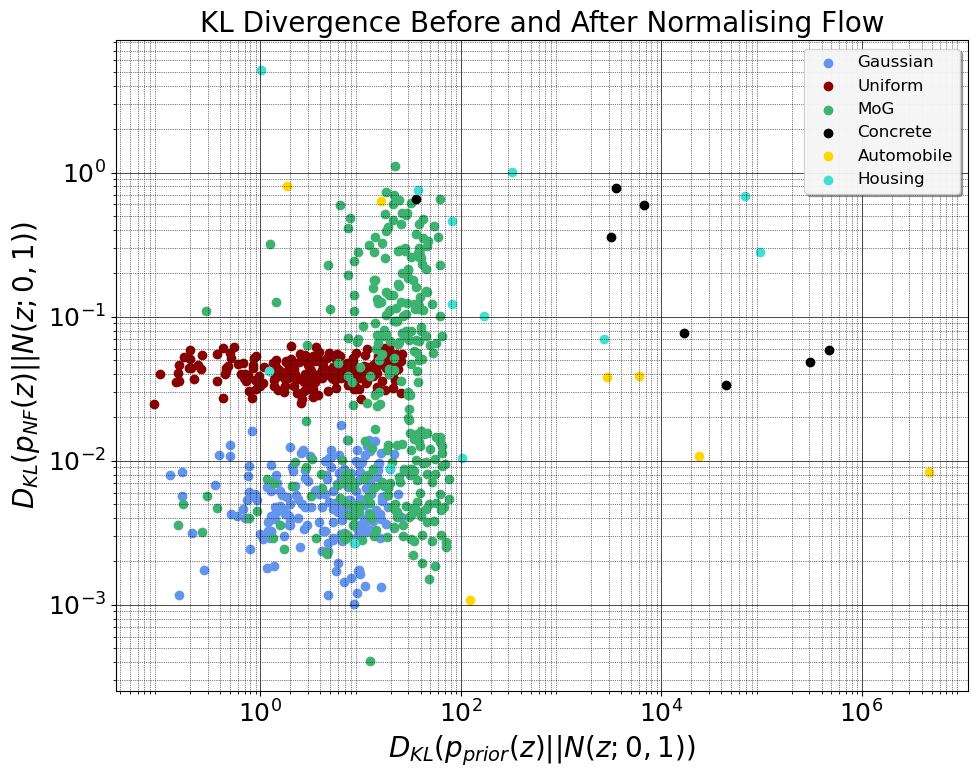

In [16]:
plt.figure(figsize=(10,8))
plt.scatter(prior_kl_gauss, post_kl_gauss, color='cornflowerblue', label='Gaussian')
plt.scatter(prior_kl_unif, post_kl_unif, color='darkred', label='Uniform')
plt.scatter(prior_kl_mog, post_kl_mog, color='mediumseagreen', label='MoG')
plt.scatter(prior_kl_concrete, post_kl_concrete, color='black', label='Concrete')
plt.scatter(prior_kl_autompg, post_kl_autompg, color='gold', label='Automobile')
plt.scatter(prior_kl_housing, post_kl_housing, color='turquoise', label='Housing')
plt.xlabel('$D_{KL}(p_{prior}(z)\\vert\\vert N(z;0,1))$')
plt.ylabel('$D_{KL}(p_{NF}(z)\\vert\\vert N(z;0,1))$')
plt.title('KL Divergence Before and After Normalising Flow', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.yticks([1e-3, 1e-2, 1e-1, 1e-0], fontsize=18)
#plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], fontsize=18)
plt.xticks([1, 100, 10000, 1000000], fontsize=18)
#plt.grid(True, which="both", axis='x', linestyle='--', linewidth=0.5)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, framealpha=0.9, fontsize=12)

plt.tight_layout()
plt.show()